## Imports needed for qiskit part

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style 

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output


## imports needed for kaggle solution https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier

## General imports

In [34]:
import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

## Scaler functions

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize_data(data, frange=(-1,1)):
    return MinMaxScaler(feature_range=frange).fit_transform(data)

def scale_data(data, with_mean=True, with_std=True):
    return StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(data)

## Classical Solution

In [36]:
heart_data = pd.read_csv('data/kaggle/heart_failure_clinical_records_dataset.csv')

# only the features used in the notebook
Features = ['time','ejection_fraction','serum_creatinine']
x = heart_data[Features]
y = heart_data["DEATH_EVENT"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2)

<AxesSubplot:>

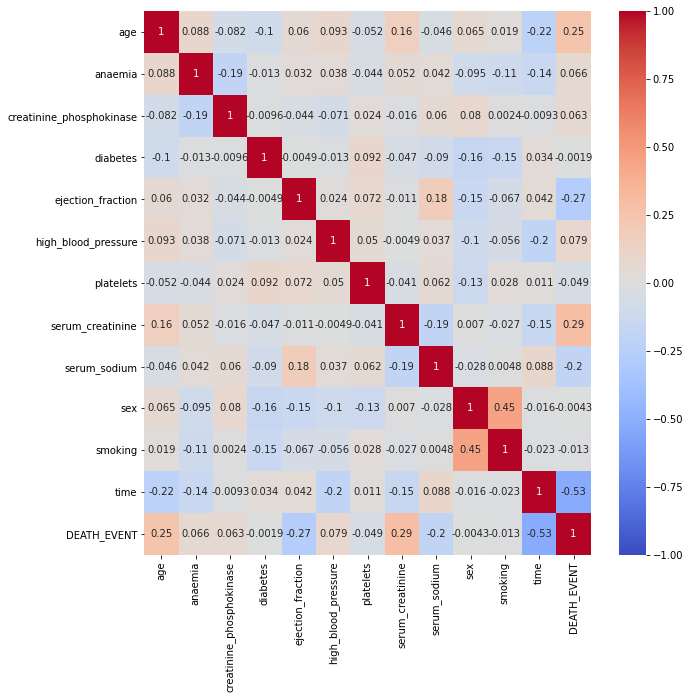

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(heart_data.corr(), vmin=-1, cmap='coolwarm', annot=True)

Accuracy MLPClassifier [size: 25, hidden layers: 1]:  88.33%


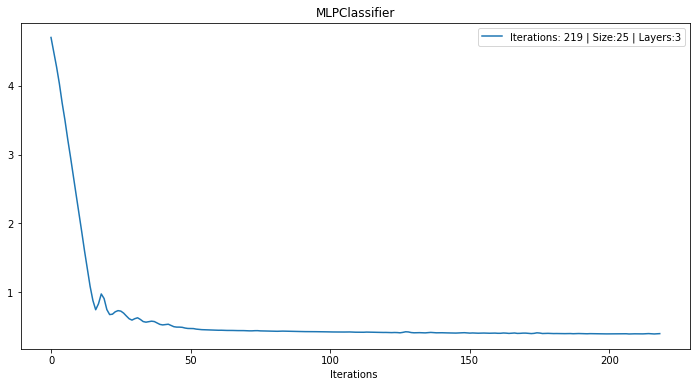

Accuracy MLPClassifier [size: 25, hidden layers: 13]:  91.67%


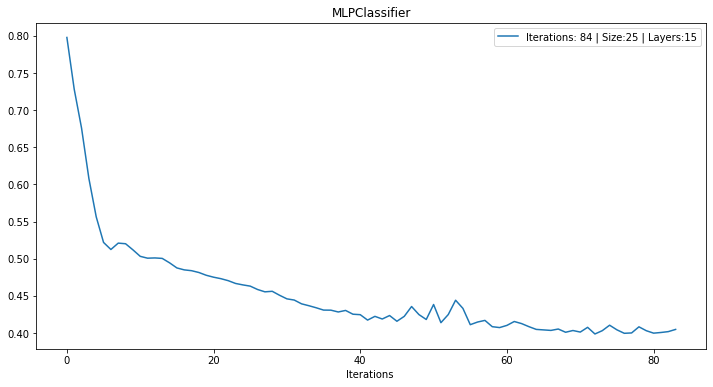

Accuracy MLPClassifier [size: 25, hidden layers: 25]:  93.33%


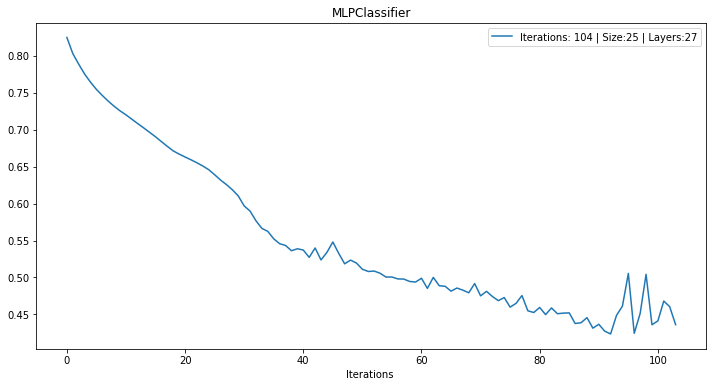

Accuracy MLPClassifier [size: 50, hidden layers: 1]:  90.00%


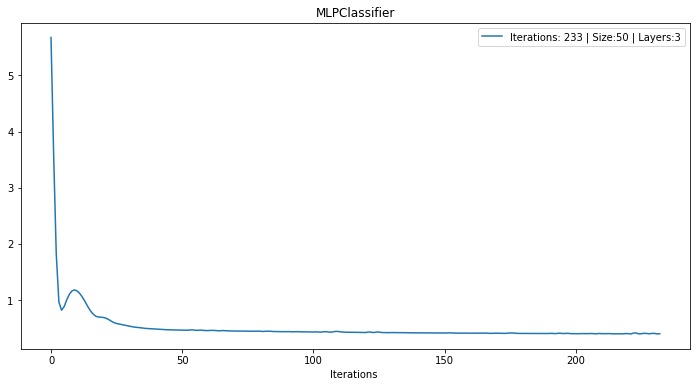

Accuracy MLPClassifier [size: 50, hidden layers: 13]:  93.33%


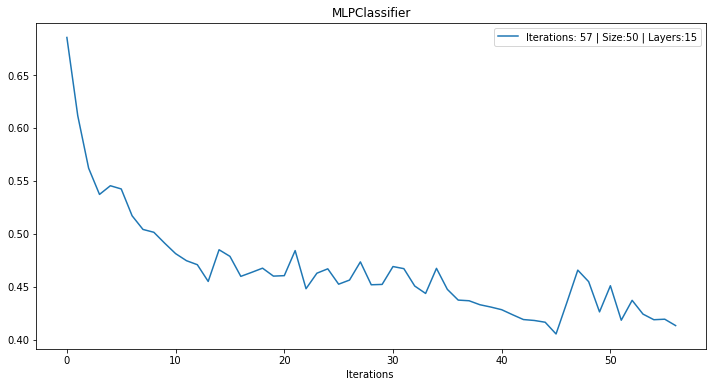

Accuracy MLPClassifier [size: 50, hidden layers: 25]:  91.67%


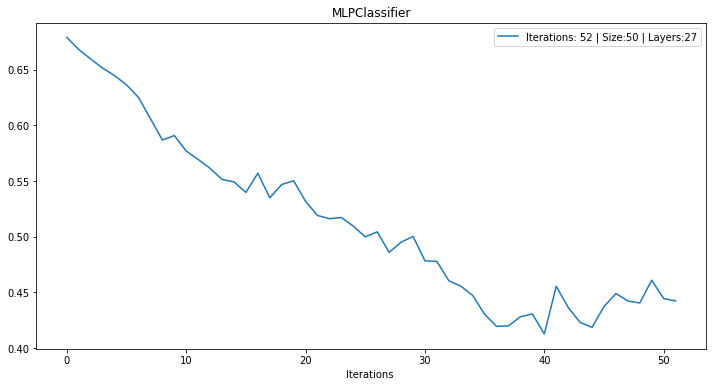

Accuracy MLPClassifier [size: 75, hidden layers: 1]:  86.67%


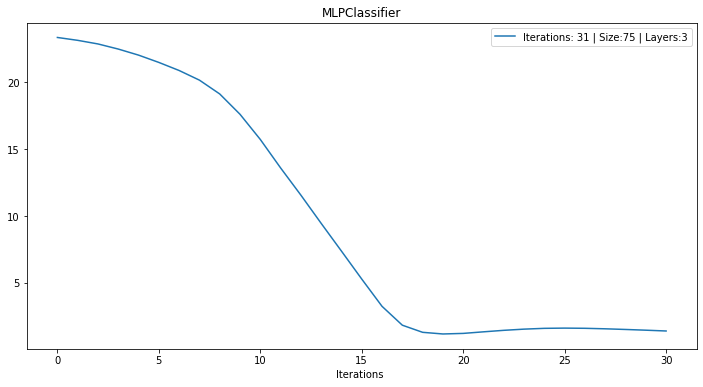

Accuracy MLPClassifier [size: 75, hidden layers: 13]:  90.00%


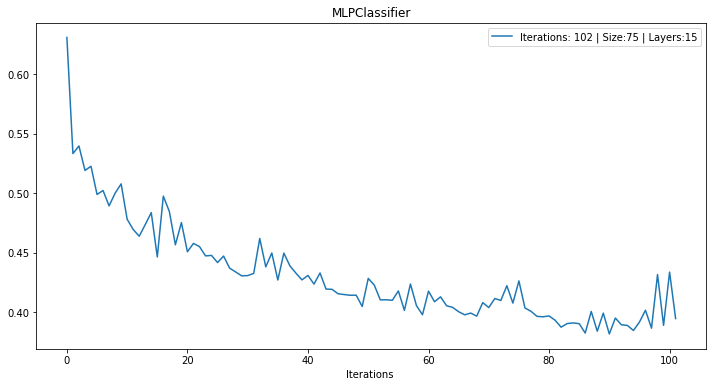

Accuracy MLPClassifier [size: 75, hidden layers: 25]:  93.33%


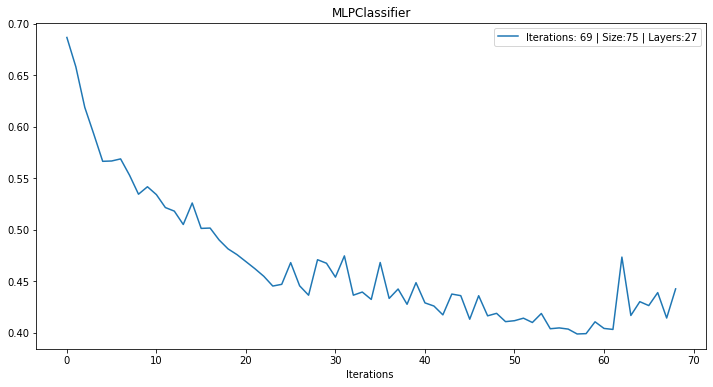

In [38]:
accuracy_list = []

for i in range(25,100,25):
  for j in range(1,31,12):
    # nn = MLPClassifier(hidden_layer_sizes=(15,4),random_state=1, max_iter=300, 
    #                   solver="sgd", nesterovs_momentum=True)
    # print(((i,)*j))
    nn = MLPClassifier(hidden_layer_sizes=(i,)*j,solver="adam", random_state=1, max_iter=300)
    nn.fit(x_train, y_train)
    nn_pred = nn.predict(x_test)
    nn_acc = accuracy_score(y_test, nn_pred)
    
    # print(nn.get_params(True))
    accuracy_list.append(100*nn_acc)

    plt.plot(range(nn.n_iter_), nn.loss_curve_, 
             label="Iterations: " + str(nn.n_iter_) + " | Size:" + str(i) + " | Layers:" + str(nn.n_layers_))
    print(Fore.GREEN + "Accuracy MLPClassifier [size: {:d}, hidden layers: {:d}]: ".format(i,j), "{:.2f}%".format(100* nn_acc))
    # plt.rcParams["figure.figsize"] = (12, 6)
    plt.xlabel("Iterations ")
    plt.title("MLPClassifier")
    plt.legend()
    plt.show()



## Quantum Solution

In [39]:
#More functions needed for training
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Original PA circuit

Original data

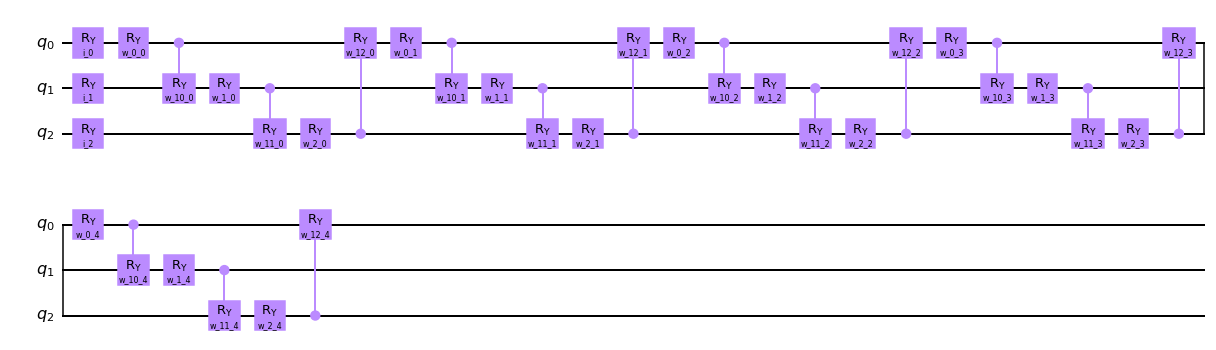

In [40]:
#Using our known, reliable circuit, we will do a comparison
def fit_and_score(circuit_classifier, x_train, y_train, x_test, y_test):

    plt.rcParams["figure.figsize"] = (12, 6)

    # fit classifier to data
    circuit_classifier.fit(x_train, y_train)
    score_train =  circuit_classifier.score(x_train, y_train)
    score_test =  circuit_classifier.score(x_test, y_test)
    print("Mean Accuracy traingin: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test)))
    print('Mean Accuracy overall: ' + str(score))

n = len(Features)
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % 2

# LAYERS
n_layers = 5

feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

# circuit
for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)
    
# layers
for l in range(n_layers):
  for i in range(n):
    ansatz.ry(Parameter('w_' + str(i) + '_' + str(l)),i)
    ansatz.cry(Parameter('w_' + str(10+i) + '_' + str(l)), i, (i+1)%n)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))
                                    


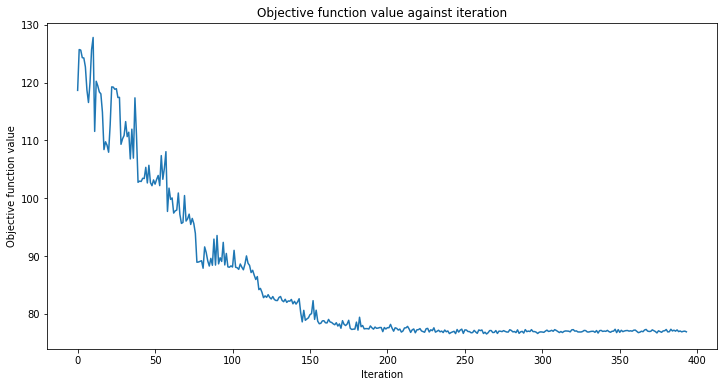

Mean Accuracy traingin: 0.7112970711297071
Mean Accuracy testing: 0.75
Mean Accuracy overall: 0.7224080267558528


In [41]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Original data (not normalized)')
fit_and_score(circuit_classifier, x_train.values, y_train.values, x_test.values, y_test.values)

## Original PA circuit

Normalized data

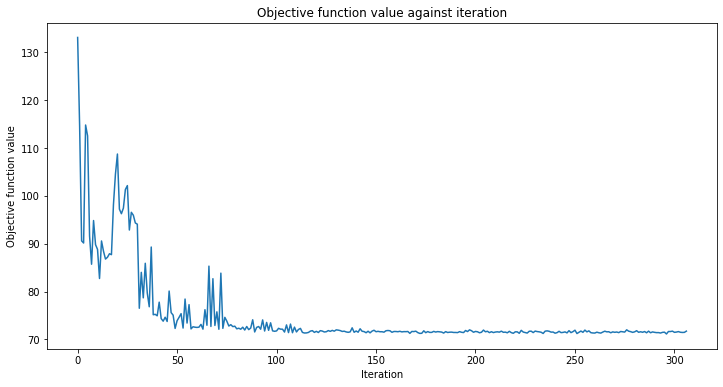

Mean Accuracy traingin: 0.698744769874477
Mean Accuracy testing: 0.75
Mean Accuracy overall: 0.7090301003344481


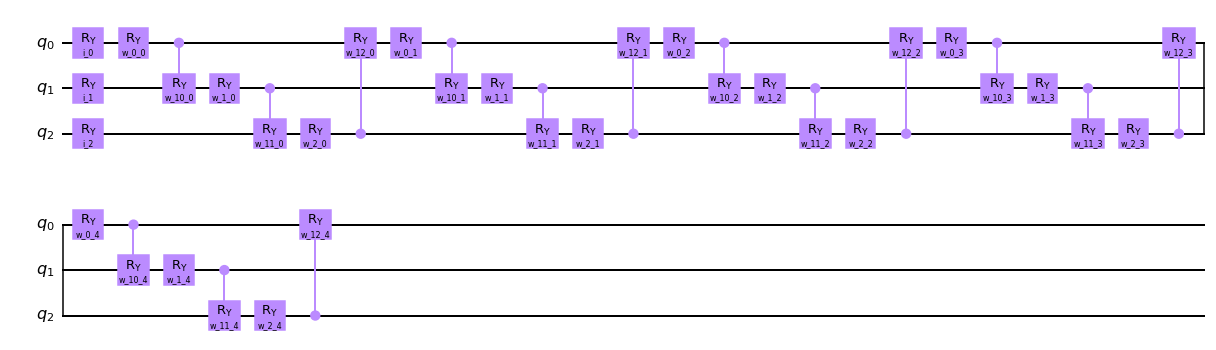

In [42]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: cascade mirrored

Normalized data

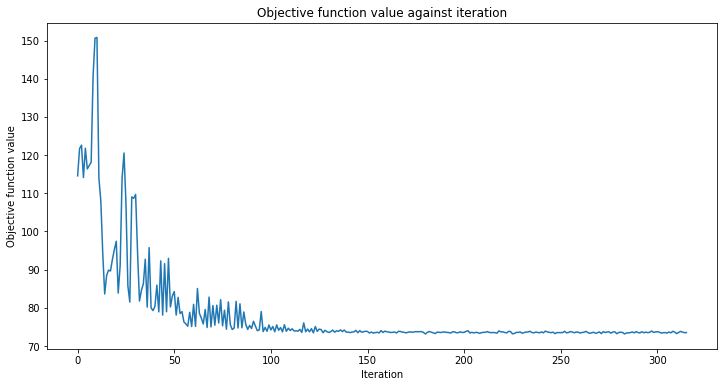

Mean Accuracy traingin: 0.6820083682008368
Mean Accuracy testing: 0.7333333333333333
Mean Accuracy overall: 0.6923076923076923


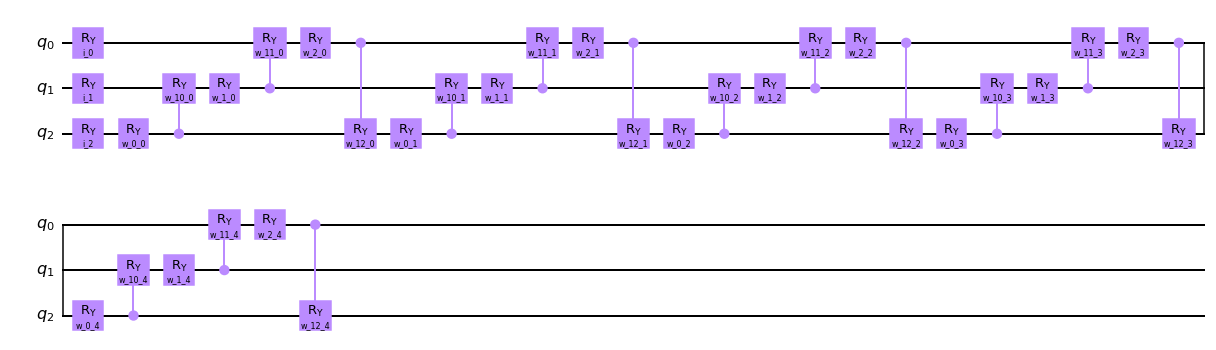

In [43]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)

# layers
for l in range(n_layers):
  ansatz.ry(Parameter('w_0_' + str(l)),2)
  ansatz.cry(Parameter('w_10_' + str(l)), 2, 1)
  ansatz.ry(Parameter('w_1_' + str(l)),1)
  ansatz.cry(Parameter('w_11_' + str(l)), 1, 0)
  ansatz.ry(Parameter('w_2_' + str(l)),0)
  ansatz.cry(Parameter('w_12_' + str(l)), 0, 2)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: Entangle all qubits with cx

Normalized data

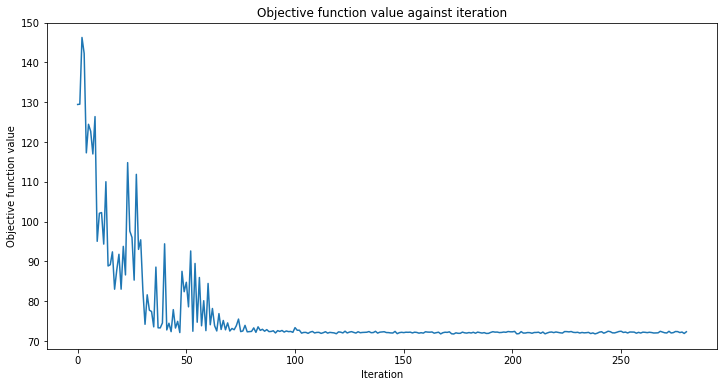

Mean Accuracy traingin: 0.6903765690376569
Mean Accuracy testing: 0.7333333333333333
Mean Accuracy overall: 0.6989966555183946


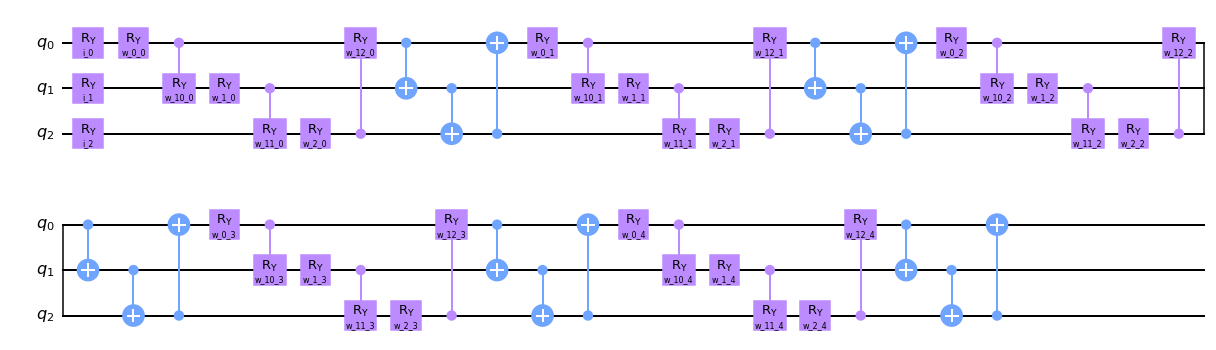

In [44]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)

# layers
for l in range(n_layers):
  for i in range(n):
    ansatz.ry(Parameter('w_' + str(i) + '_' + str(l)),i)
    ansatz.cry(Parameter('w_' + str(10+i) + '_' + str(l)), i, (i+1)%n)
  # cx gates
  ansatz.cx(0,1)
  ansatz.cx(1,2)
  ansatz.cx(2,0)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: Entangle all qubits with ccx

Normalized data


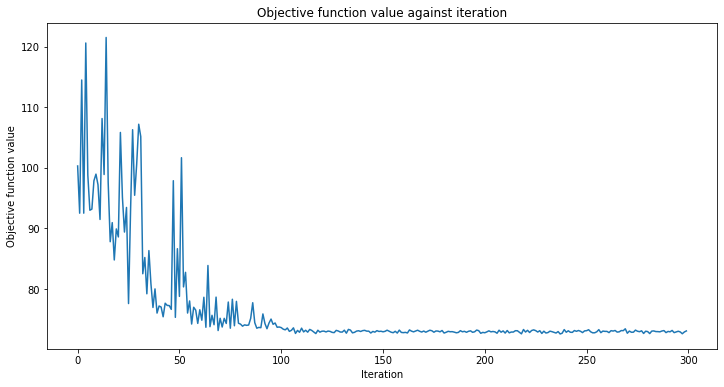

Mean Accuracy traingin: 0.6903765690376569
Mean Accuracy testing: 0.7333333333333333
Mean Accuracy overall: 0.7023411371237458


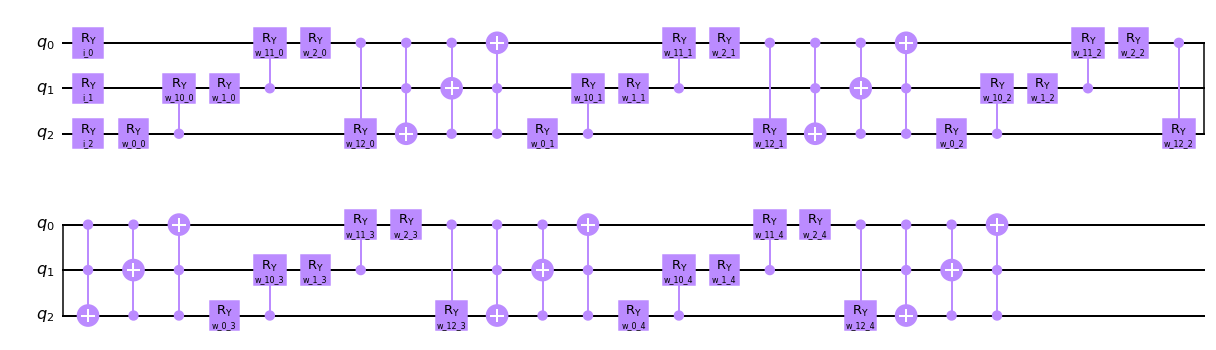

In [45]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)

# layers
for l in range(n_layers):
  ansatz.ry(Parameter('w_0_' + str(l)),2)
  ansatz.cry(Parameter('w_10_' + str(l)), 2, 1)
  ansatz.ry(Parameter('w_1_' + str(l)),1)
  ansatz.cry(Parameter('w_11_' + str(l)), 1, 0)
  ansatz.ry(Parameter('w_2_' + str(l)),0)
  ansatz.cry(Parameter('w_12_' + str(l)), 0, 2)
  # ccx gates
  ansatz.ccx(0,1,2)
  ansatz.ccx(0,2,1)
  ansatz.ccx(2,1,0)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: Hadamard start and end

Normalized data

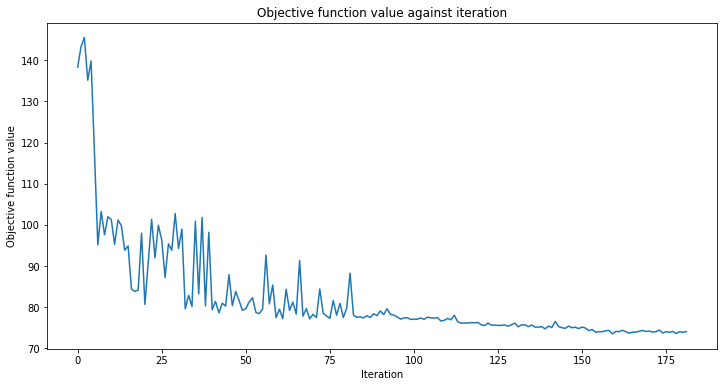

In [46]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.h(i)
    feature_map.ry(Parameter('i_' + str(i)),i)
    
# layers
for l in range(n_layers):
  for i in range(n):
    ansatz.ry(Parameter('w_' + str(i) + '_' + str(l)),i)
    ansatz.cry(Parameter('w_' + str(10+i) + '_' + str(l)), i, (i+1)%n)
  ansatz.h(0)
  ansatz.h(1)
  ansatz.h(2)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: More weights (UGate)
Normalized data

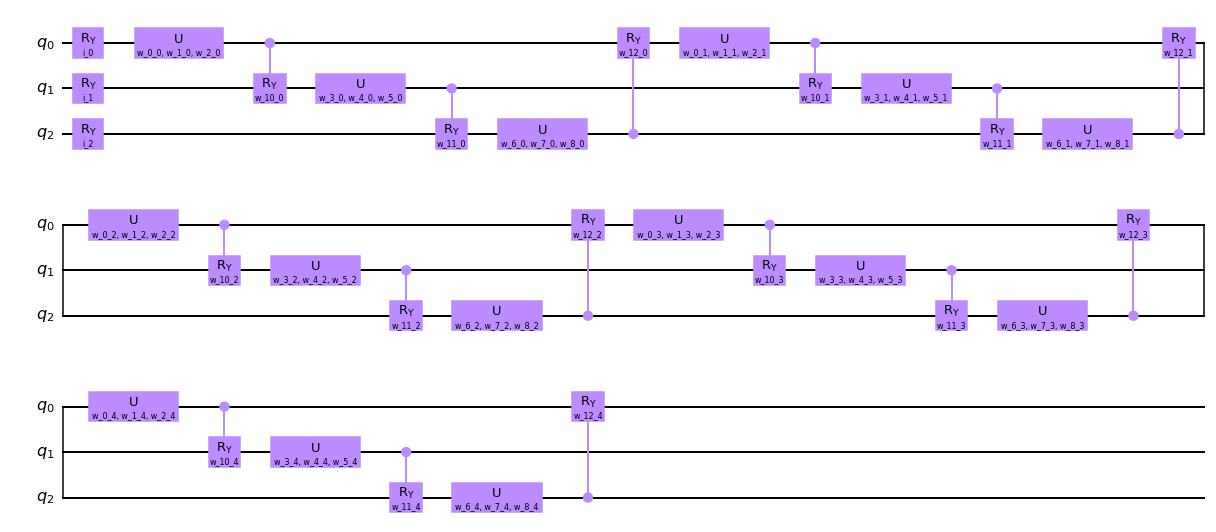

Normalized data


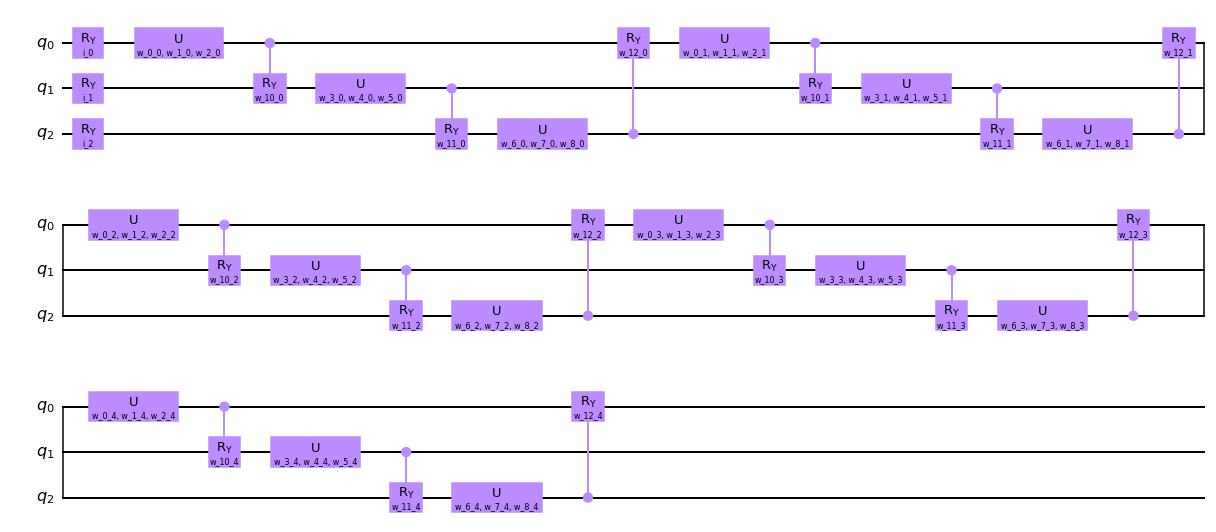

In [ ]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)

# layers
for l in range(n_layers):
  ansatz.u(Parameter('w_0_' + str(l)),Parameter('w_1_' + str(l)),Parameter('w_2_' + str(l)),0)
  ansatz.cry(Parameter('w_10_' + str(l)), 0, 1)
  ansatz.u(Parameter('w_3_' + str(l)),Parameter('w_4_' + str(l)),Parameter('w_5_' + str(l)),1)
  ansatz.cry(Parameter('w_11_' + str(l)), 1, 2)
  ansatz.u(Parameter('w_6_' + str(l)),Parameter('w_7_' + str(l)),Parameter('w_8_' + str(l)),2)
  ansatz.cry(Parameter('w_12_' + str(l)), 2, 0)
    
qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values
display(qc.decompose().draw('mpl'))

## PA circuit: More weights (UGate), no entanglement
Normalized data

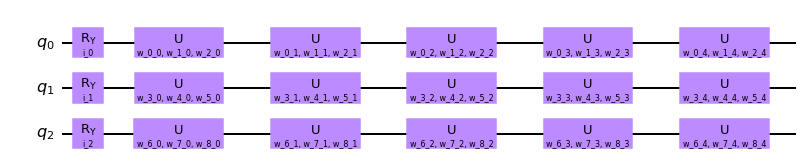

Normalized data


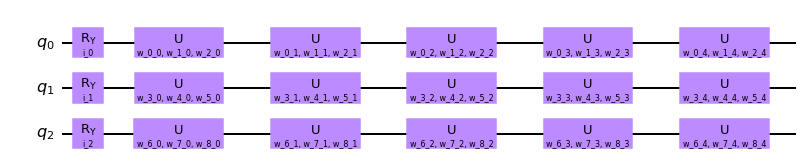

In [ ]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)

# layers
for l in range(n_layers):
  ansatz.u(Parameter('w_0_'+ str(l)),Parameter('w_1_'+ str(l)),Parameter('w_2_'+ str(l)),0)
  ansatz.u(Parameter('w_3_'+ str(l)),Parameter('w_4_'+ str(l)),Parameter('w_5_'+ str(l)),1)
  ansatz.u(Parameter('w_6_'+ str(l)),Parameter('w_7_'+ str(l)),Parameter('w_8_'+ str(l)),2)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: Early cx gates, ugate
Normalized data

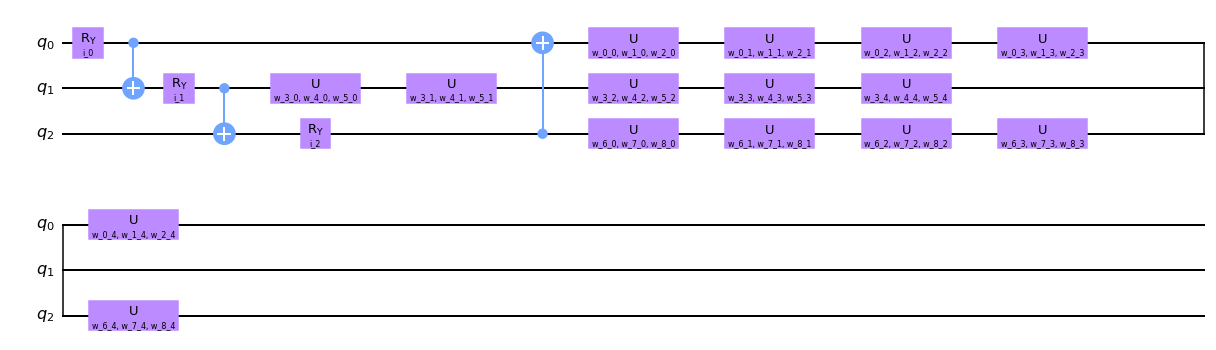

Normalized data


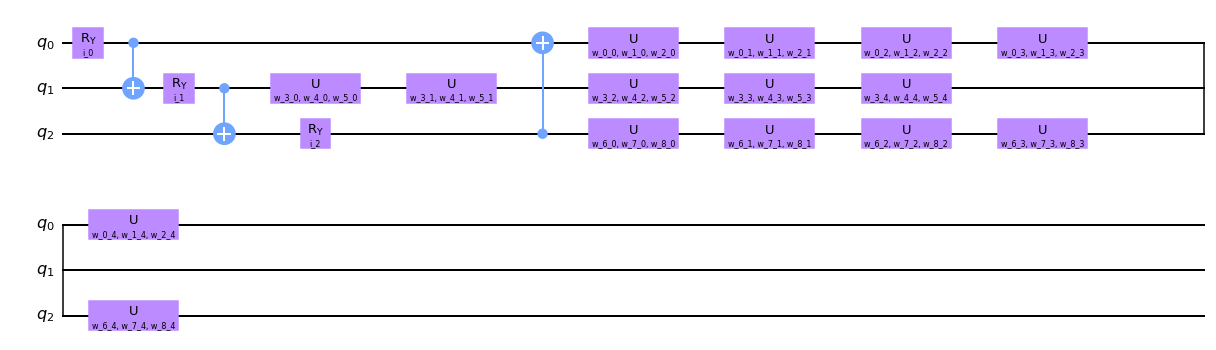

In [ ]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

# curcuit
feature_map.ry(Parameter('i_0'),0)
feature_map.cx(0,1)
feature_map.ry(Parameter('i_1'),1)
feature_map.cx(1,2)
feature_map.ry(Parameter('i_2'),2)
feature_map.cx(2,0)

# layers
for l in range(n_layers):
  ansatz.u(Parameter('w_0_'+ str(l)),Parameter('w_1_'+ str(l)),Parameter('w_2_'+ str(l)),0)
  ansatz.u(Parameter('w_3_'+ str(l)),Parameter('w_4_'+ str(l)),Parameter('w_5_'+ str(l)),1)
  ansatz.u(Parameter('w_6_'+ str(l)),Parameter('w_7_'+ str(l)),Parameter('w_8_'+ str(l)),2)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: Ugate and cx instead of ry and cry
Normalized data

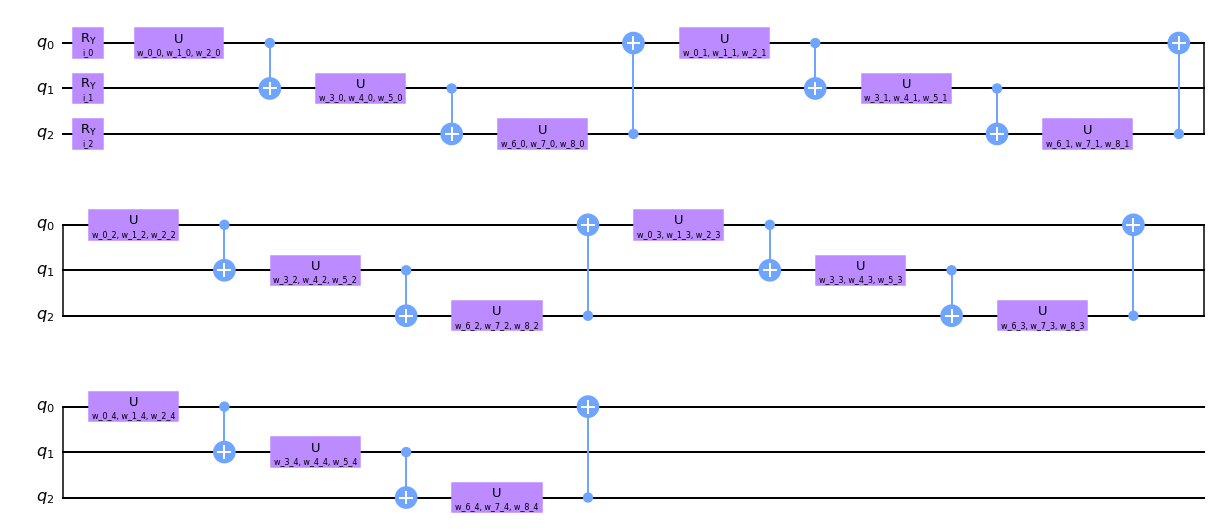

Normalized data


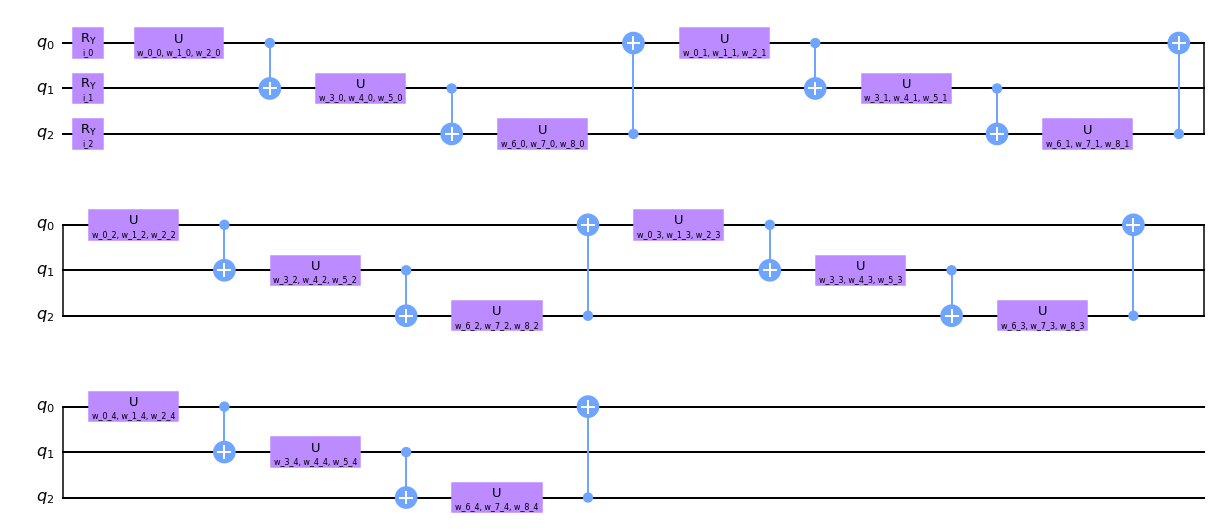

In [ ]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)

# layers
for l in range(n_layers):
  ansatz.u(Parameter('w_0_'+ str(l)),Parameter('w_1_'+ str(l)),Parameter('w_2_'+ str(l)),0)
  ansatz.cx(0,1)
  ansatz.u(Parameter('w_3_'+ str(l)),Parameter('w_4_'+ str(l)),Parameter('w_5_'+ str(l)),1)
  ansatz.cx(1,2)
  ansatz.u(Parameter('w_6_'+ str(l)),Parameter('w_7_'+ str(l)),Parameter('w_8_'+ str(l)),2)
  ansatz.cx(2,0)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))

## PA circuit: only features and two weights
Normalized data

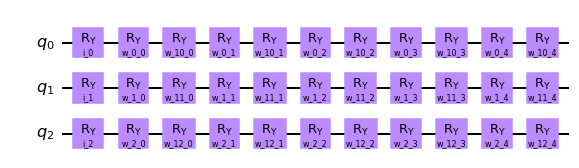

Normalized data


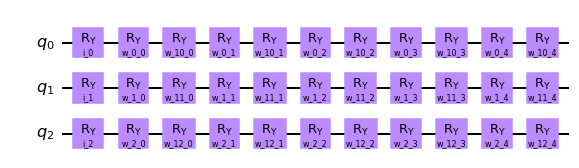

In [ ]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)
    
# layers
for l in range(n_layers):
  for i in range(n):
    ansatz.ry(Parameter('w_' + str(i)+ '_' + str(l)),i)
    ansatz.ry(Parameter('w_1' + str(i)+ '_' + str(l)),i)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
print('Normalized data')        
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
display(qc.decompose().draw('mpl'))